In [40]:
import os
from langchain_community.document_loaders import CSVLoader

file_path = 'final_preprocessed_music_data.csv' 

loader = CSVLoader(
    file_path=file_path,
    content_columns=['track_name', 'artist_name', 'lyrics', 'genre'],
    encoding='utf-8'
)

docs = loader.load()
docs_subset = docs[6400:6600]
print(docs_subset[0].page_content)

genre: industrial
lyrics: 
artist_name: Area 11
track_name: Dream & Reality


In [41]:
embed_nomic = OllamaEmbeddings(model="nomic-embed-text")

In [42]:
def calculate_recall_at_k(vectorstore, eval_data, k_list=[1, 3, 5, 10]):
    recalls = []
    for k in k_list:
        hits = 0
        temp_retriever = vectorstore.as_retriever(search_kwargs={"k": k})
        for item in eval_data:
            # 쿼리 정제
            query = item['query'].split(":")[-1].strip().replace('"', '')
            true_content = item['ground_truth']
            docs = temp_retriever.invoke(query)
            if any(true_content == d.page_content for d in docs):
                hits += 1
        recall = hits / len(eval_data)
        recalls.append(recall)
        print(f"Recall@{k}: {recall:.2%}")
    return recalls

--- 4종류의 Vector Store 구축 시작 ---

[FAISS (L2)] 평가 중...
Recall@1: 20.00%
Recall@3: 40.00%
Recall@5: 50.00%
Recall@10: 60.00%

[FAISS (Cos)] 평가 중...
Recall@1: 20.00%
Recall@3: 40.00%
Recall@5: 50.00%
Recall@10: 60.00%

[Chroma (L2)] 평가 중...
Recall@1: 10.00%
Recall@3: 10.00%
Recall@5: 10.00%
Recall@10: 10.00%

[Chroma (Cos)] 평가 중...
Recall@1: 10.00%
Recall@3: 10.00%
Recall@5: 10.00%
Recall@10: 10.00%


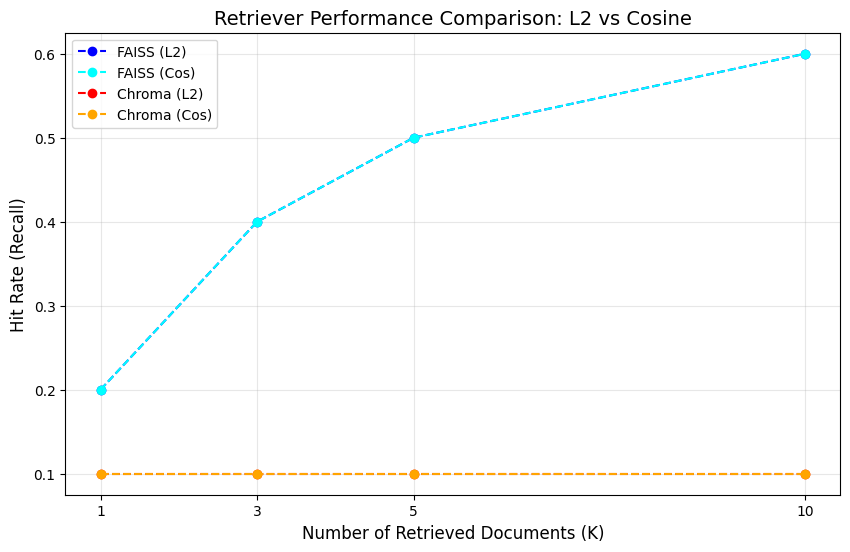

In [43]:
from langchain_ollama import OllamaEmbeddings
from langchain_community.vectorstores import FAISS, Chroma
from langchain_community.vectorstores.utils import DistanceStrategy

print("--- 4종류의 Vector Store 구축 시작 ---")

faiss_l2 = FAISS.from_documents(docs_subset, embed_nomic, 
                                 distance_strategy=DistanceStrategy.EUCLIDEAN_DISTANCE)
retriever_faiss_l2 = faiss_l2.as_retriever(search_kwargs={"k": 5})

faiss_cos = FAISS.from_documents(docs_subset, embed_nomic, 
                                  distance_strategy=DistanceStrategy.COSINE)
retriever_faiss_cos = faiss_cos.as_retriever(search_kwargs={"k": 5})

# Chroma
chroma_l2 = Chroma.from_documents(docs_subset, embed_nomic, 
                                   collection_metadata={"hnsw:space": "l2"})
retriever_chroma_l2 = chroma_l2.as_retriever(search_kwargs={"k": 5})

chroma_cos = Chroma.from_documents(docs_subset, embed_nomic, 
                                    collection_metadata={"hnsw:space": "cosine"})
retriever_chroma_cos = chroma_cos.as_retriever(search_kwargs={"k": 5})


k_values = [1, 3, 5, 10]
results = {}

for name, vstore in [("FAISS (L2)", faiss_l2), ("FAISS (Cos)", faiss_cos), 
                     ("Chroma (L2)", chroma_l2), ("Chroma (Cos)", chroma_cos)]:
    print(f"\n[{name}] 평가 중...")
    results[name] = calculate_recall_at_k(vstore, eval_set, k_values)

plt.figure(figsize=(10, 6))
colors = {'FAISS (L2)': 'blue', 'FAISS (Cos)': 'cyan', 'Chroma (L2)': 'red', 'Chroma (Cos)': 'orange'}

for name, recalls in results.items():
    plt.plot(k_values, recalls, marker='o', label=name, color=colors[name], linestyle='--')

plt.title('Retriever Performance Comparison: L2 vs Cosine', fontsize=14)
plt.xlabel('Number of Retrieved Documents (K)', fontsize=12)
plt.ylabel('Hit Rate (Recall)', fontsize=12)
plt.xticks(k_values)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [44]:
def evaluate_retriever_improved(name, retriever, eval_data, k=5):
    print(f"\n{'='*20} [{name}] Evaluation (Top-{k}) {'='*20}")
    hits = 0

    for i, item in enumerate(eval_data):
        query = item['query']

        clean_query = query.split(":")[-1].strip().replace('"', '')

        true_content = item['ground_truth']
        docs = retriever.invoke(clean_query)

        is_hit = any(true_content == d.page_content for d in docs)

        if is_hit:
            hits += 1
            status = "✅ [HIT]"
        else:
            status = "❌ [MISS]"

        print(f"Q{i+1} {status} Query: {clean_query}...")
        if not is_hit:
            print(f"   └ Expected: {true_content}...")
            print(f"   └ Top-1 Found: {docs[0].page_content}...")

    score = hits / len(eval_data)
    print(f"\n>>> {name} Final Hit Rate@{k}: {score:.2%}")
    return score

In [45]:
retrievers = {
    "FAISS (L2)": retriever_faiss_l2,
    "FAISS (Cosine)": retriever_faiss_cos,
    "Chroma (L2)": retriever_chroma_l2,
    "Chroma (Cosine)": retriever_chroma_cos
}

print("--- Retriever 성능 비교 (Hit Rate@5) ---")
for name, r in retrievers.items():
    score = evaluate_retriever_improved(name, r, eval_set, k=5)
    print(f"{name}: {score:.2%}")

--- Retriever 성능 비교 (Hit Rate@5) ---

==================== [FAISS (L2)] Evaluation (Top-5) ====================
Q1 ✅ [HIT] Query: patriotic musical show tunes about the country...
Q2 ✅ [HIT] Query: Right place good girl dynamite jump shout...
Q3 ✅ [HIT] Query: pain that hurts like hell...
Q4 ❌ [MISS] Query: baby I'm feeling nostalgic and sad...
   └ Expected: genre: garage
lyrics: 
artist_name: Ariel Pink;DāM-FunK
track_name: Baby...
   └ Top-1 Found: genre: sad
lyrics: 
artist_name: Aries
track_name: BLOSSOM...
Q5 ❌ [MISS] Query: song about longing and nostalgia...
   └ Expected: genre: singer-songwriter
lyrics: 
artist_name: Arijit Anand;Mitraz
track_name: Saaye...
   └ Top-1 Found: genre: blues
lyrics: precious memories linger flood soul stillness midnight precious sacred scenes unfold precious father love mother lonely years home scenes childhood fond memory appear stillness midnight echo past hear oldtime sing gladness bring lovely land travel life pathway know years hold ponder g